# &#127859;Cooking Agent with Prompt and GoogleSearch Grounding
---

**AI Cooking Agent** that provides cooking advice and solves endless questions on what to eat
- Recommend based on the available ingredients
    - either, user typed input
    - or, the image of grocery receipt (**image understanding**)
- Take additional input on cooking time, the number of people to feed and the cuisine style
- Use **one-shot prompt** to summarize cooking ingredients from the receipt image in **structured output** and also the recommended recipes 
- Provide the sources based on **google search grounding**


## Install packages

In [1]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

## Import packages

In [2]:
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages.ai import AIMessage

from google.genai import types
from google.ai.generativelanguage_v1beta.types import Tool as GenAITool

import base64
import io
import requests
from PIL import Image as IMAGE
from IPython.display import Image, display, Markdown


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


## Set up API KEY

- if needed, check https://aistudio.google.com/app/apikey on how to create the api key

In [5]:
import os

try: # try kaggle scretes assuming kaggle notebook
    from kaggle_secrets import UserSecretsClient
    
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
except Exception as e: # if failed, then allow to input offline
    import os
    import getpass
    if "GOOGLE_API_KEY" not in os.environ:
        os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

## Define the prompt
1. system intruction to define the role
2. require to ask for user to specify the ingridient or just use the image of grocery receipt
3. additional instruction for the online search result w/ requirement to validate the link before display to the customer

In [6]:
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.

CookingBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a smart and resourceful chatbot that can recommend the recipe for daily cooking. A human will talk to you about the "
    "meals to prepare. You will answer any questions and make proposal about the cooking and meals."
    "First, please ask the customer to provide a list of availabble ingredients and if possible, the image of receipt from the grocery store to figure out what the customer has already."
    "Hold other questions until the ingredients are confirmed. Then, ask the customer to clarify the cooking time the customer has and how many people to feed and if there is any restriction or preference like Chinese or Fresh cuisine, spicy or mild"
    "Afterwards, implement the search tools to ground search recipes and output the recipes. Each recipe must include four sections, i.e. 'Recipe', 'Ingredients', 'Instructions' and 'Source'. Always, specify the associated urls from ground search for the Source of the recipe. See the example below"
    # one shot prompt to define the output format including the Source of the websites/videos from the ground search
    """
    Example:
    ```
    **Recipe**: Sauteed Chinese Sausage
    **Ingredients**: Chinese sausage, garlic, onion, spring onions, soy sauce.
    **Instructions**: Steam the sausages for 15 minutes, then slice and saute with garlic, onion, and spring onions. Add soy sauce and serve.
    **Source**: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK6YTqtNwS5vO5UDcCsx-j9EnMH9gD9HSFFag0-OPYUuYl8Ln-KR6d0wfQ8p0pWReWPwlYnkx7VCQXjO9KyR7IjlGFbYeXhkgU9Xe44XoRtK8iwf0fgehoHxTXC-O6AfFxwsc7LFwhh2nR6TTSIW4e-fCscr1vyz8sU9m3QXehX
    ```
    """
    "\n\n"
    "Please only return the videos and websites that don't return error"
    "Please only discuss the recommended dished and what to eat; nothing else"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)


# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the CookingBot. Type `q` to quit. Do you need any recommendation on today's meals?"



## Define the graph

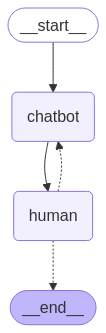

In [7]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

class OrderState(TypedDict):
    """State representing the state of conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool

def image_prompt(img_url):
    """
    Convert the image and define the prompt for model processing
    Use one-shot prompt to help define the output format
    """
    try:
        img = IMAGE.open(img_url)
    except OSError:
        response = requests.get(img_url)
        if response.status_code == 200:
            # Open the image using PIL from the response content
            img = IMAGE.open(io.BytesIO(response.content))
        else:
            print(f"Failed to retrieve {img_url}. HTTP Status code: {response.status_code}")
        
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")
    img_bytes = buffered.getvalue()
    base64_str = base64.b64encode(img_bytes).decode()
    img_base64 = f"data:image/jpeg;base64,{base64_str}"

    # one shot prompt
    prompt = '''
    output the items in the image that are related to the food in Markdown table format . See example below
    Example:
    '|Item|Price|Quantity (Units)|
    |rice|30|10 lb|'
    '''

    messages = [
        {'role': 'system', 'content': prompt},
        {'role': 'user',
         'content': [
                {'type': 'image_url', 'image_url': {'url': img_base64}}
            ]
        }
    ]
    return messages

def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("\nModel:")
    if isinstance(last_msg.content,str):
        display(Markdown(last_msg.content))
    else:
        for message in last_msg.content:
            display(Markdown(message))
            # if 'csv' in message:
            #     message = message.replace('csv','').replace("`","")
            #     print(message)
            # elif 'markdown' in message:
            #     display(Markdown(message))
            # else: 
            #     display(Markdown(message))
    user_input = input("\nUser (when done, type `q` to quit): ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True
    if user_input.endswith('.jpg'):
        state['receipt'] = user_input
        state['image_needed'] = True
    output = state | {"messages": [("user", user_input)]}
    return output


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """
    The chatbot itself. A wrapper around the model's own chat interface.
    w/ the google search grounding
    """
    defaults = {"receipt": state.get('receipt',None), "finished": False, 
                "image_needed":state.get('image_needed',False), 'items':None}
    messages = state['messages']
    if len(messages)>0:
        human_message = messages[-1].content
        # print('chabot input messages')
        if human_message.endswith('.jpg') or (human_message.startswith('https') and 'jpg' in human_message):
            state['receipt'] = human_message
            state['image_needed'] = True
            messages = image_prompt(human_message)
    if messages:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([CookingBOT_SYSINT] + messages,
                               tools=[GenAITool(google_search={})],
                               )
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    output = defaults | state | {"messages": [new_output]}
    return output


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)
# graph_builder.add_node("image",image_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human")
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

## Run the cooking agent

In [8]:
config = {"recursion_limit": 100} # up to 100 rounds of interaction
state = chat_with_human_graph.invoke({"messages": []}, config)


Model:


Welcome to the CookingBot. Type `q` to quit. Do you need any recommendation on today's meals?


User (when done, type `q` to quit):  yes



Model:


Great! To give you the best recommendations, could you please tell me:

1.  What ingredients do you have available right now? If possible, could you share an image of your grocery receipt?
2.  How much time do you have to cook?
3.  How many people are you cooking for?
4.  Are there any dietary restrictions or preferences (e.g., vegetarian, gluten-free, पसंद, spicy, mild, Chinese, Italian, Fresh)?


User (when done, type `q` to quit):  https://preview.redd.it/sa4bzhkgewj81.jpg?width=1080&crop=smart&auto=webp&s=9ac096a63307fd03795d789348051862c3d9d407



Model:


Okay, I've analyzed the receipt. Here's a list of the food items you have:

| Item                       |   Price | Quantity (Units) |
|:---------------------------|--------:|-----------------:|
| Diced Tomatoes             |    0.67 |                  |
| Tomato Paste               |    0.75 |                  |
| Wheat Bread                |    4.49 |                  |
| Parmesan Cheese (Shredded) |    3.89 |                  |
| Impossible Burger          |    7.59 |                  |
| Boneless Chicken Breast    |   12.18 |                  |
| Light Vanilla Yogurt       |    2.00 |                  |
| Limes                      |    1.74 |                  |
| Chicken Broth              |    5.99 |                  |
| Peanut Butter              |    5.75 |                  |
| Green Beans                |    0.89 |                  |
| Tomato Ketchup             |    6.39 |                  |
| Green Bell Peppers         |    2.84 | 1.14 lb          |
| Red Bell Peppers           |    2.19 | 0.55 lb          |
| Organic Carrots            |    1.69 |                  |
| Banana Shallots            |    1.40 | 0.20 lb          |

To give you the best recommendations, could you tell me:

1.  How much time do you have to cook?
2.  How many people are you cooking for?
3.  Are there any dietary restrictions or preferences (e.g., cuisine type, spice level)?


User (when done, type `q` to quit):  30min for three. Mexican spicy



Model:


Here are a couple of spicy Mexican-inspired recipes you can make in about 30 minutes, using your available ingredients:

**Recipe:** One-Pan Spicy Chicken Fajitas

**Ingredients:**

*   1 lb Boneless Chicken Breast, sliced
*   1 Red Bell Pepper, sliced
*   1 Green Bell Pepper, sliced
*   1/2 Banana Shallot, sliced
*   3 cloves Garlic, minced (adjust to taste)
*   1 can (6oz) El Pato hot tomato sauce (or substitute with your diced tomatoes + a pinch of cayenne pepper for heat)
*   1 tsp Chili powder
*   1/2 tsp Cumin
*   1/2 tsp Smoked paprika
*   1/2 tsp Oregano
*   Juice of 2 Limes
*   Salt and Pepper to taste
*   Wheat Tortillas
*   Optional toppings: shredded Parmesan cheese

**Instructions:**

1.  Preheat oven to 425 degrees Fahrenheit
2.  In a large skillet, heat some cooking oil over medium-high heat. Add the sliced chicken breast to the skillet and cook for 5-7 minutes, or until the chicken is thoroughly cooked.
3.  Add the cumin, smoked paprika, chili powder, oregano, garlic, salt, pepper, and lime juice and mix together. Let the dried herbs release flavor for about 3 minutes or until fragrant.
4.  Add the sliced bell peppers and shallots and mix together; let it cook until the veggies are tender, about 3-5 minutes.
5.  Add the can of El Pato hot tomato sauce and mix together. Reduce heat to medium-low and let the chicken and veggies simmer for about 7 minutes.
6.  While the skillet is simmering, warm up tortillas.
7.  Serve fajitas with tortillas and your favorite toppings.

**Source:** [https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJSkKVML4wRgLUD3JZWDZgVG60FyjLmbgkV2OUL-hR5IjyF8iMO30XsINmaNrXYejC\_wGcX5JyTpZRHGDschFWvbDtGGGCOw9tlZjBblmos9bMPypow5ai9PA6KA9C\_Jzlo9wyvYD3eVsvnjn\_vEZY32nfFzWTAy69ZJHEcZw==](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJSkKVML4wRgLUD3JZWDZgVG60FyjLmbgkV2OUL-hR5IjyF8iMO30XsINmaNrXYejC_wGcX5JyTpZRHGDschFWvbDtGGGCOw9tlZjBblmos9bMPypow5ai9PA6KA9C_Jzlo9wyvYD3eVsvnjn_vEZY32nfFzWTAy69ZJHEcZw==)

**Recipe:** Impossible Burger Street Tacos

**Ingredients:**

*   1 package Impossible Burger
*   1/2 Banana Shallot, chopped
*   3 cloves Garlic, minced
*   1 1/2 tablespoons Chili Powder (or to taste, for spice)
*   Salt and pepper to taste
*   Wheat Tortillas
*   1 Tomato, diced
*   Lime wedges

**Instructions:**

1.  Heat a skillet over medium heat. Add Impossible Burger and cook until fully browned, about 10 minutes.
2.  Mix in 1/2 of the chopped shallot, minced garlic, salt, chili powder and cumin. Cook and stir over low heat until fragrant, about 5 minutes.
3.  Spray a separate skillet with cooking spray and warm wheat tortillas over low heat until lightly toasted, about 30 seconds per side.
4.  Assemble your tacos with the Impossible Burger filling, remaining raw shallot, diced tomato, and cilantro. Squeeze some lime juice over the tacos and serve remaining wedges alongside.

**Source:** [https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJIXLeIzvGljxux8f43sdDBXJlbyCWFzNzqinLaSBmRg8OLrMYevIIfJBhLBJekKDROVvEeKUosy1N0\_WAqLvP4z7lf2PErkCet3LHZIgSaMNFPQ\_R3BKj8aIoXq7RvZdUcnTQuEXsCfGVAHM6t4Gj3zqvP0KEjbBelg4N2vfRfK6g\_](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJIXLeIzvGljxux8f43sdDBXJlbyCWFzNzqinLaSBmRg8OLrMYevIIfJBhLBJekKDROVvEeKUosy1N0_WAqLvP4z7lf2PErkCet3LHZIgSaMNFPQ_R3BKj8aIoXq7RvZdUcnTQuEXsCfGVAHM6t4Gj3zqvP0KEjbBelg4N2vfRfK6g_)

Enjoy your meal!


User (when done, type `q` to quit):  q
